**Task #1: Understand the problem statement and business**

The goal of this project is to detect fake news using Recurrent Neural
Nerworks(RNN). Natural language processors work by converting words or texts into numbers. These numbers are then used to train an AI/ML models to make predictions. AI/ML based fake news detector is crucial for companies and media to automatically predict whether circulating news is fake or not. Here, we are going to analyze thousands of news text to detect fake or not.

**Task #2: Import libraries and datasets**

In [1]:
#!pip install --upgrade tensorflow-gpu==2.0
!pip install 'tensorflow[and-cuda]'

!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy # spaCy is an open-source software library for advanced natural language processing
!pip install WordCloud
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
!pip install jupyterthemes

In [3]:
import tensorflow
print(tensorflow.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

nltk.download('punkt')
nltk.download('punkt_tab')

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
# setting the style of the notebook to be monokai theme

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# load the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

**Task #3: Perform Exploratory Data Analysis**

We can check how many data samples do we have per class (i.e.: Fake and True)

In [6]:
df_true.shape

(21417, 4)

In [7]:
df_fake.shape

(23481, 4)

Check how many **NULL** elements are present and the memory usage for each dataframe

In [8]:
df_fake.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [9]:
df_true.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [10]:
df_true.info()
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [11]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_true.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [12]:
df_fake['isfake'] = 0
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [13]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [14]:
df.shape

(44898, 5)

In [15]:
df.drop(columns = ['date'], inplace = True) # drop date column as we are not considering in this case

In [16]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [17]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

**Task #4: Perform Data Cleaning**

In [18]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [19]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

In [20]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [21]:
# Show original news
df['original'][1]

'U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District 

In [22]:
# Show cleaned up news after removing stopwords
print(df['clean'][1])

['military', 'accept', 'transgender', 'recruits', 'monday', 'pentagon', 'washington', 'reuters', 'transgender', 'people', 'allowed', 'time', 'enlist', 'military', 'starting', 'monday', 'ordered', 'federal', 'courts', 'pentagon', 'said', 'friday', 'president', 'donald', 'trump', 'administration', 'decided', 'appeal', 'rulings', 'blocked', 'transgender', 'federal', 'appeals', 'courts', 'washington', 'virginia', 'week', 'rejected', 'administration', 'request', 'hold', 'orders', 'lower', 'court', 'judges', 'requiring', 'military', 'begin', 'accepting', 'transgender', 'recruits', 'justice', 'department', 'official', 'said', 'administration', 'challenge', 'rulings', 'department', 'defense', 'announced', 'releasing', 'independent', 'study', 'issues', 'coming', 'weeks', 'litigate', 'interim', 'appeal', 'occurs', 'administration', 'decided', 'wait', 'study', 'continue', 'defend', 'president', 'lawful', 'authority', 'district', 'court', 'meantime', 'official', 'said', 'speaking', 'condition', 'a

In [23]:
df.head(2)

,title,text,subject,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."


In [24]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [25]:
list_of_words[:5]

['budget', 'fight', 'looms', 'republicans', 'flip']

In [26]:
len(list_of_words)

9276947

In [27]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [28]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [29]:
df.head()

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


In [30]:
df['clean_joined'][0] #Perform sanity check on the prepocessing stage by visualizing sample news

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

**Task #5: Visualize Cleaned up dataset**

In [31]:
df.head(2)

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...


<Axes: xlabel='count', ylabel='subject'>

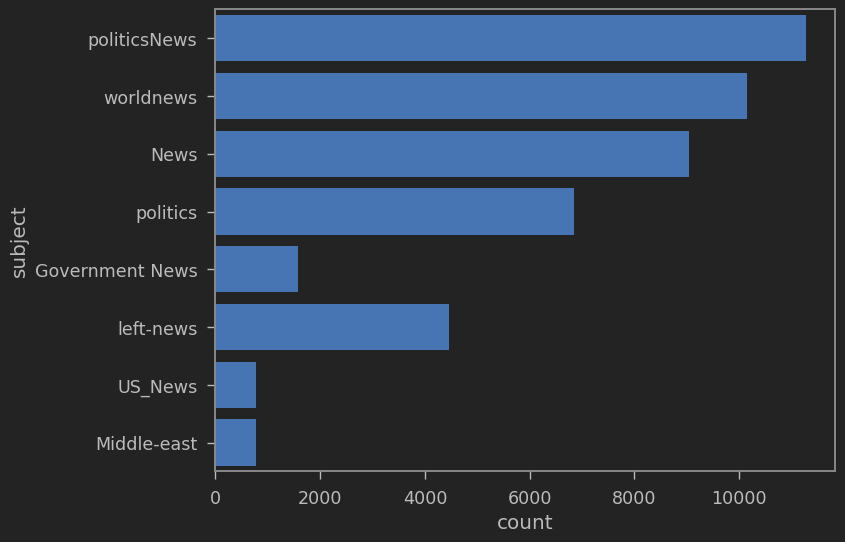

In [32]:
# plot the number of samples in 'subject'
plt.figure(figsize = (8, 6))
sns.countplot(y = "subject", data = df)

Plot the count plot for fake vs. true news

<Axes: xlabel='count', ylabel='isfake'>

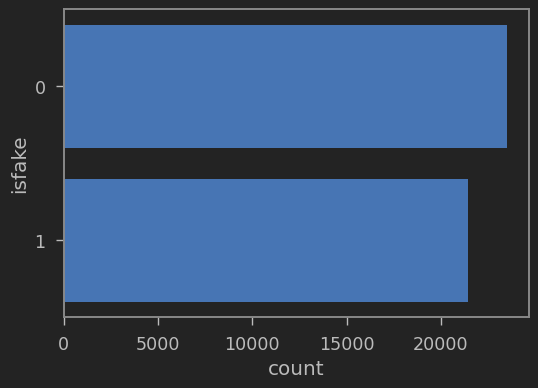

In [33]:
plt.figure(figsize = (6, 4))
sns.countplot(y = "isfake", data = df)

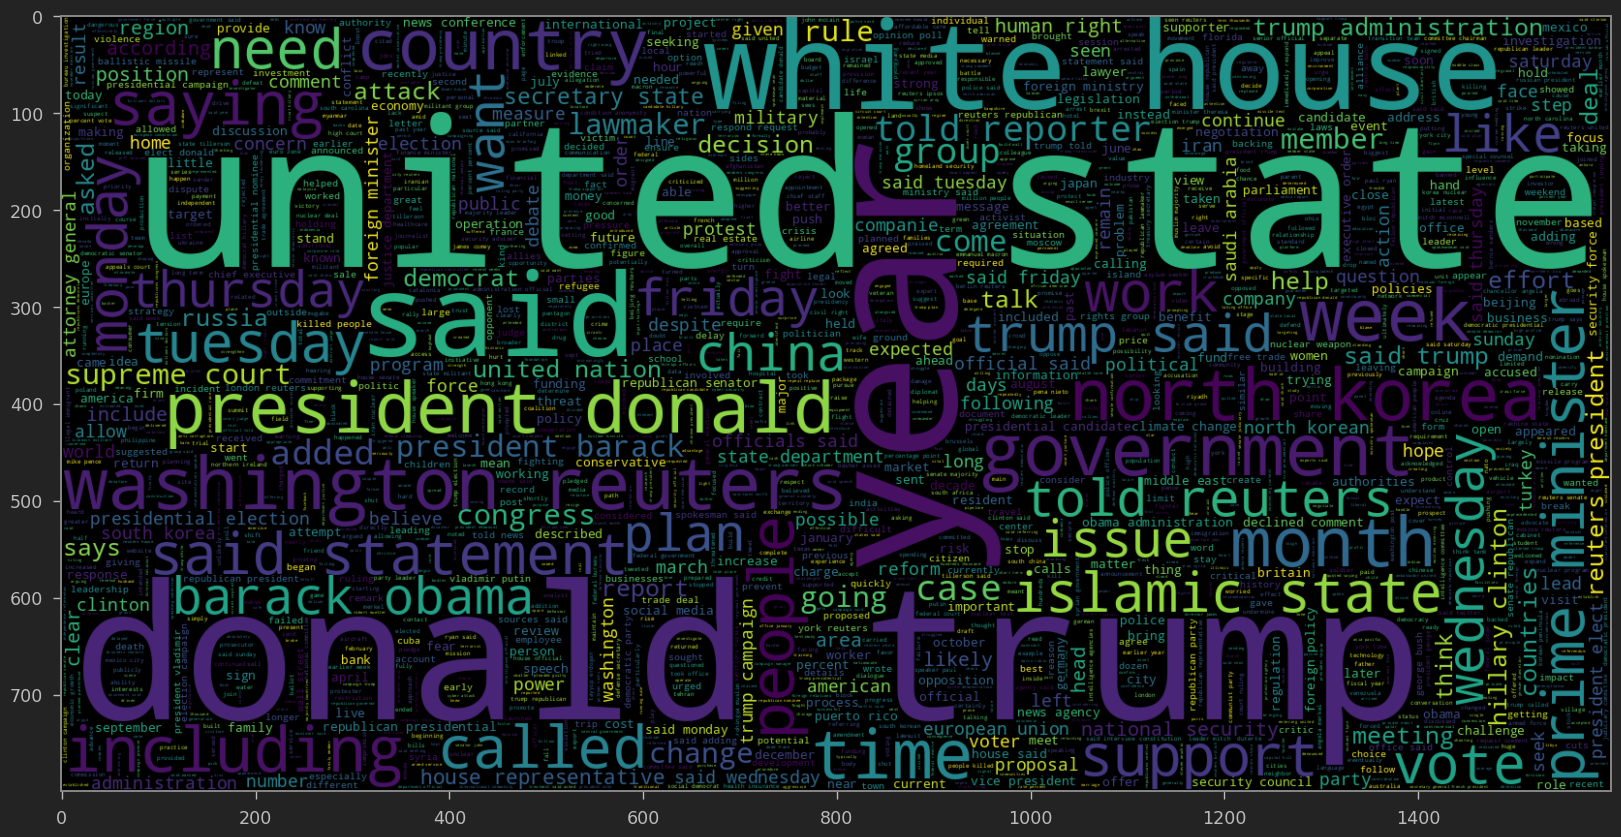

In [34]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

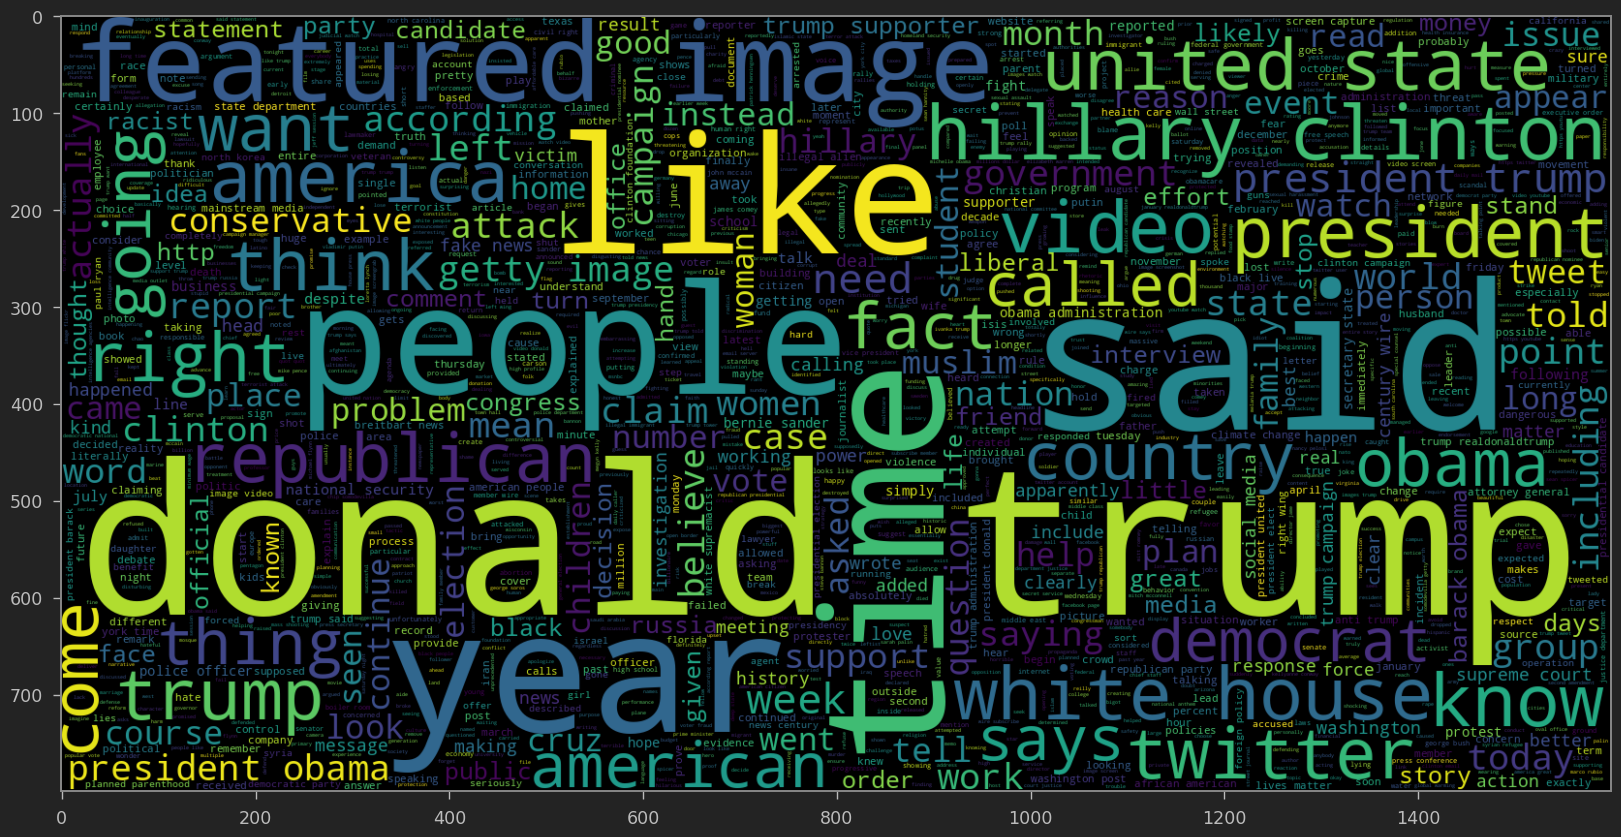

In [35]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [36]:
# length of maximum document will be needed to create word embeddings
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [64]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

**Task #6: Prepare the data by performing tokenization and padding**

In [38]:
# split data into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [65]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [66]:
print("The encoding for document\n",df.clean_joined[2],"\n is : ",train_sequences[2])

The encoding for document
 senior republican senator mueller washington reuters special counsel investigation links russia president trump election campaign continue interference despite calls trump administration allies republican lawmakers shut prominent republican senator said sunday lindsey graham serves senate armed forces judiciary committees said department justice special counsel robert mueller needs carry russia investigation political interference investigation forward investigation conducted political influence graham said face nation news program need mueller think right right time question russia interfered election trump campaign links ordinated effort loomed white house trump took office january shows sign receding trump prepares second year power despite intensified rhetoric trump allies recent weeks accusing mueller team bias republican president trump undercut supporters interview week york times said expected mueller going fair russia role election question possible 

In [67]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post')

In [68]:
padded_train[5]

array([ 1563, 17509,  8737,  3790,   122,   359,  5235, 13024,  1811,
           9,  1563,  2474,   309,   876,    60,   140,   620,  7320,
         253,   240, 17510,  1930,  8737,  3790,   122,   359,  1563,
         310,   196,  5235,  1811,   238,  4062,   831,   547,  1302,
        2922,   307,   826,   308], dtype=int32)

In [69]:
for i,doc in enumerate(padded_train[:3]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [   38  8931  7495  1245  5493  1637     1   598 10572  7628    10     1
  2338   229    44   271   197   312 21205  6606  3524   106   830    15
     8   631  4837 15497 11893   310   783   762   156    60    13   886
 35136  3223   108  1443]
The padded encoding for document 2  is :  [1232   70  601 3248    1  263  417    9 1232 2765   70  601 7714 4668
   54    3   10    1 2298   14 1232  208 5389 4280    2   77    2  769
 4765  141 1562  601 4804 4280   17  313  196    1 8569 9496]
The padded encoding for document 3  is :  [  850   836   214   596    82    17   201   385     6    27  5263   237
 17885    11  1463  1822 14746 10372     3    61  2062    37   165   134
  1907   300 30433    33    61   680   180 14986   902   881    64   993
  1425  4696   437  3054]


**Intuition behind the RNN and LSTM**


Feedforward Neural Networks that map a fixed size input such as image to a fixed output classes. They don't have any time dependency and memory effect. So RNN solves the problem here.  

Vanillla RNN has issues like vanishing gradient. To resolve that issue we can use LSTM.

**Task #7: Build and Train the Model**

In [70]:
model = Sequential()
model.add(Embedding(total_words, output_dim = 128))
model.add(LSTM(128))

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
y_train = np.asarray(y_train)

In [72]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - acc: 0.9247 - loss: 0.1320 - val_acc: 0.9994 - val_loss: 0.0020
Epoch 2/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - acc: 0.9991 - loss: 0.0052 - val_acc: 0.9989 - val_loss: 0.0100


Here, will try to change the embedding output dimension and print out the model summary.

We can check how many trainable parameters are there after dimension change.


**Task #8: Accuracy/performance of trained Model**

In [73]:
# make prediction
pred = model.predict(padded_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [74]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [75]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.994988864142539


<Axes: >

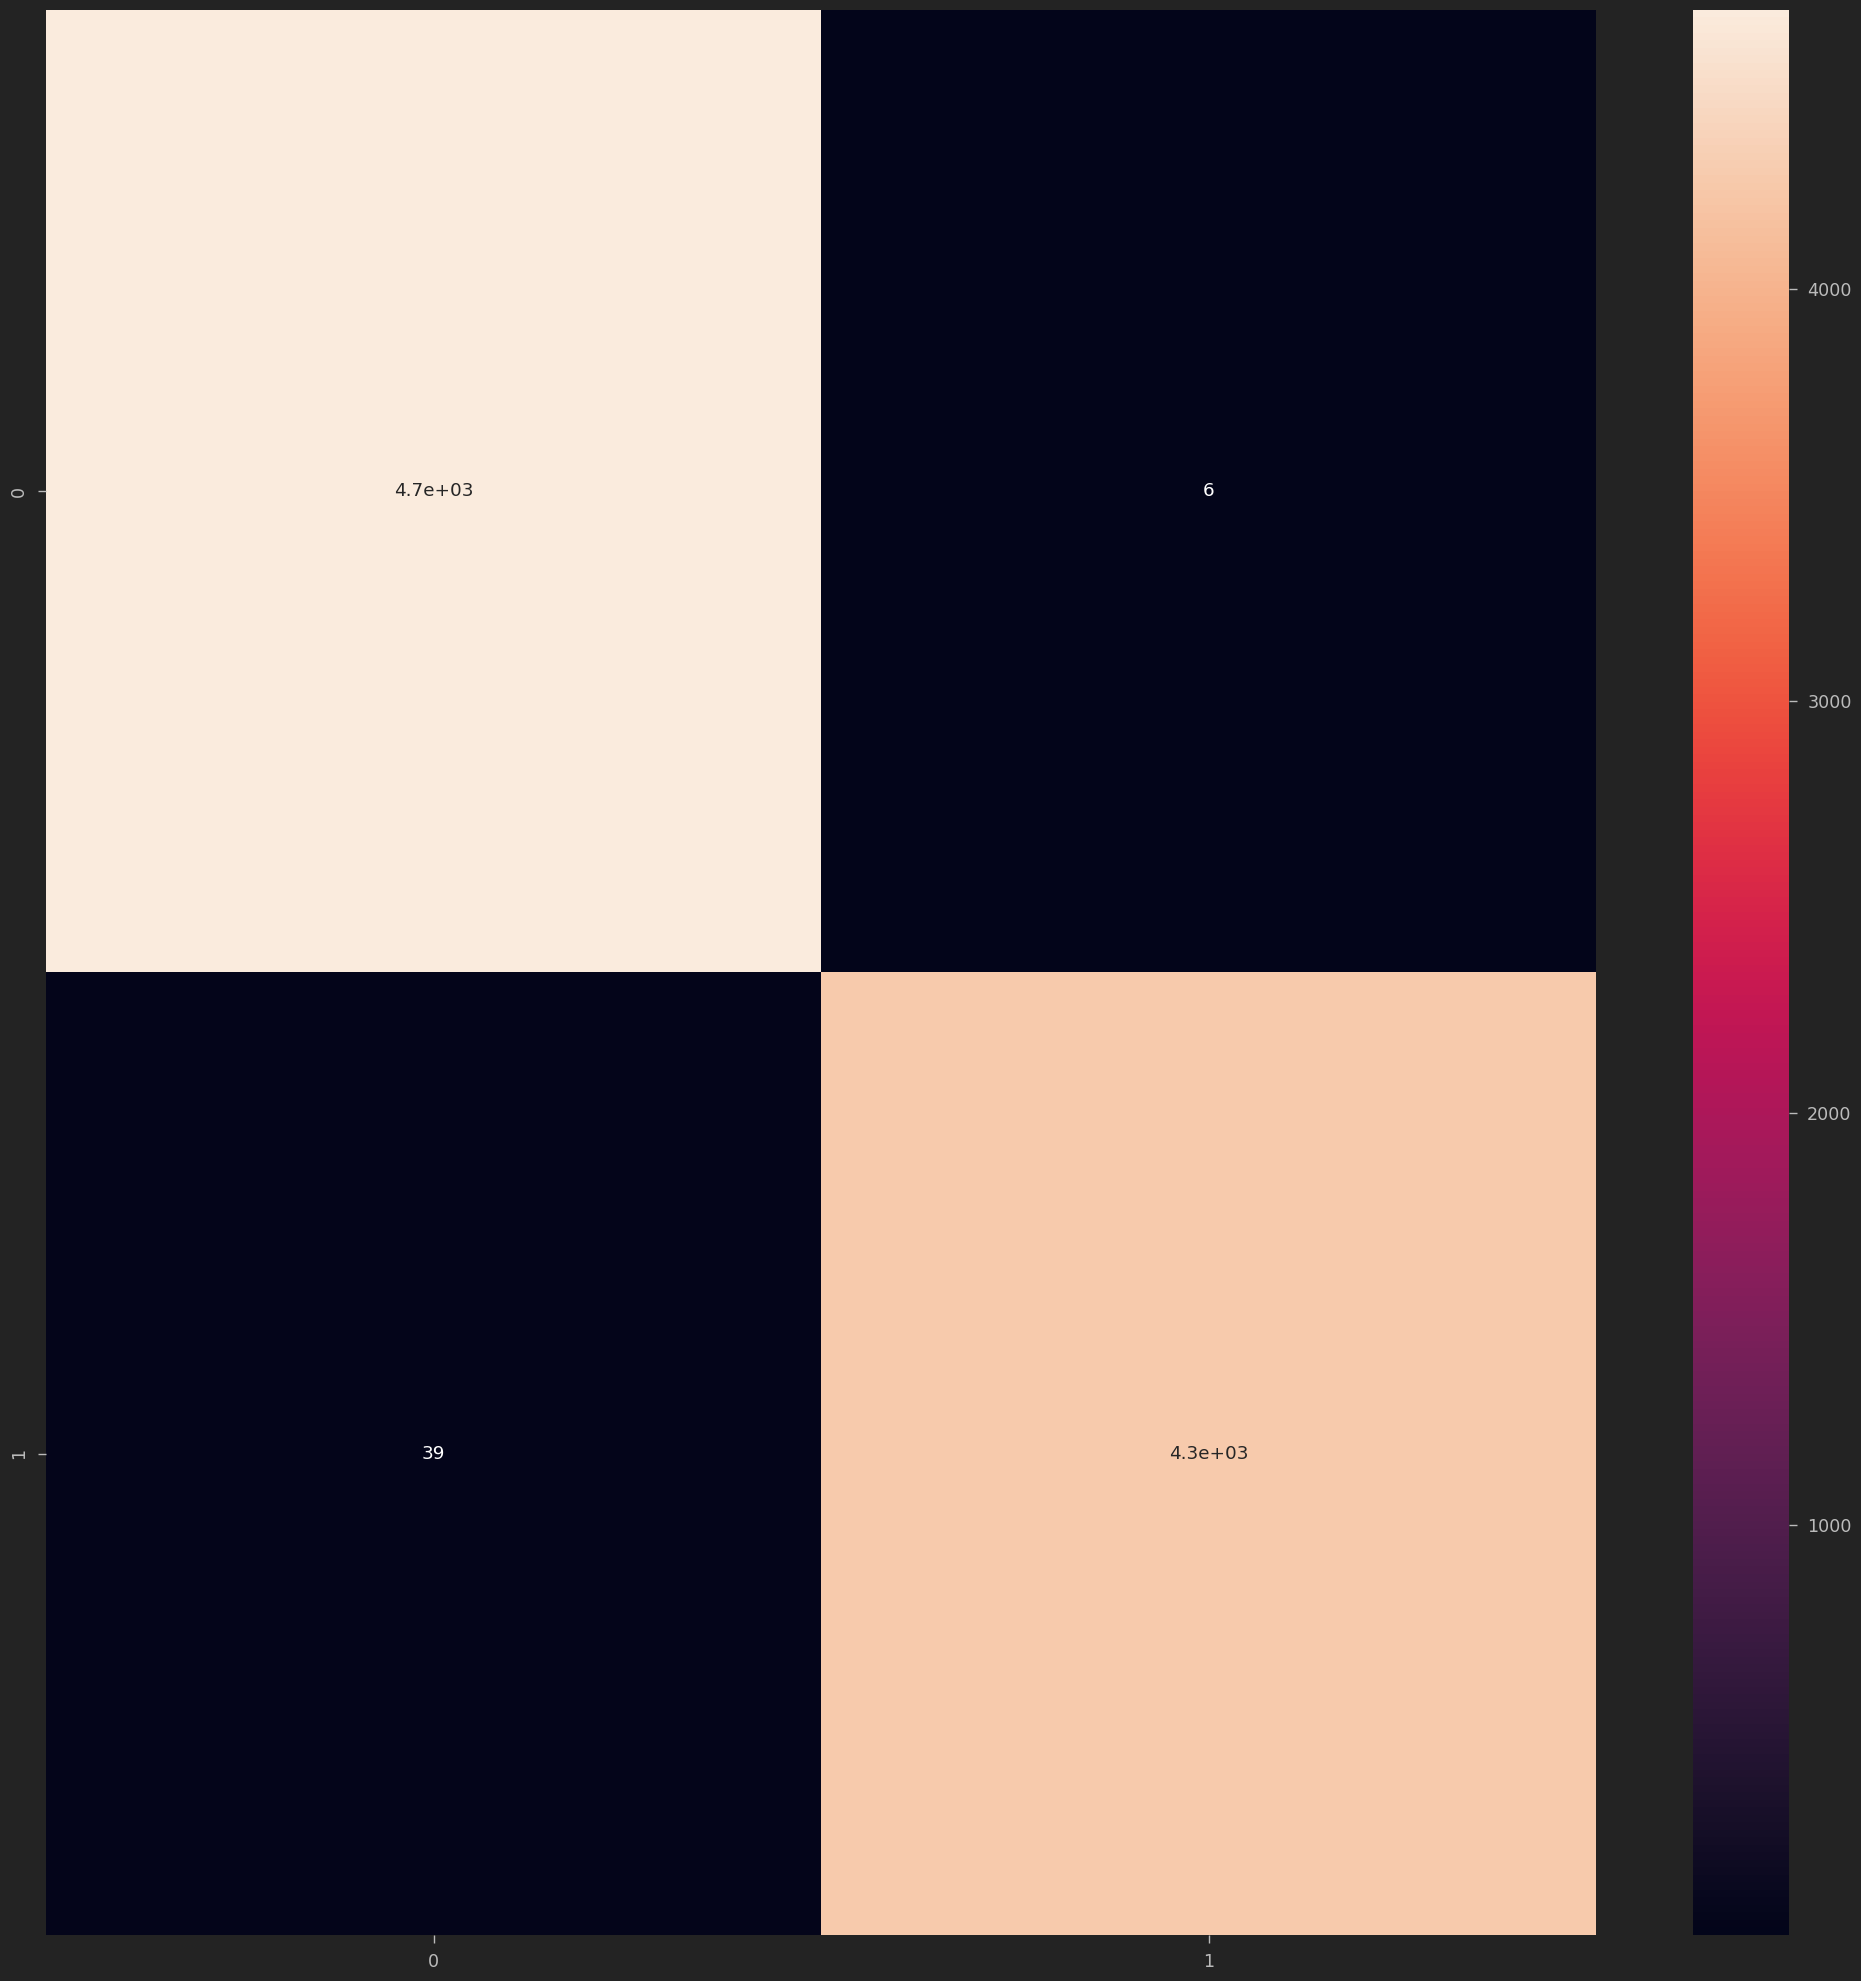

In [76]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [77]:
# category dict
category = { 0: 'Fake News', 1 : "Real News"}

In [78]:
category

{0: 'Fake News', 1: 'Real News'}